# Summary : Research file for using transfer learning for performing poses classificastion

In [1]:
import numpy as np
import pandas as pd 

In [2]:
#importing all the required libraries 
import torchvision 
import torch 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

In [3]:
def seed_all(seed):
    if not seed:
        seed = 10

    print("[ Using Seed : ", seed, " ]")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    #random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_all(20)

[ Using Seed :  20  ]


In [4]:
transform = transforms.Compose([
                                transforms.Resize((224,224)), 
                                transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.CenterCrop(220)
                               ])

In [5]:
#loading the data which is seperated into different folders as 
train_data_set_path = '/kaggle/input/yoga-dataset-project/TRAIN/TRAIN'
train_data_set = torchvision.datasets.ImageFolder(root = train_data_set_path, transform = transform )
test_data_set_path = '/kaggle/input/yoga-dataset-project/TEST/TEST'
test_data_set = torchvision.datasets.ImageFolder(root = test_data_set_path, transform = transform )

In [6]:
batch = 8
train_loader = torch.utils.data.DataLoader(train_data_set,batch_size = batch, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data_set,batch_size = batch, shuffle = True)
#valid_loader = torch.utils.data.DataLoader(valid_data_set,batch_size = batch, shuffle = True)

In [7]:
print("Training data of yoga poses are:",len(train_loader.dataset))
print("Testing data of yoga poses are:",len(test_loader.dataset))

Training data of yoga poses are: 1081
Testing data of yoga poses are: 470


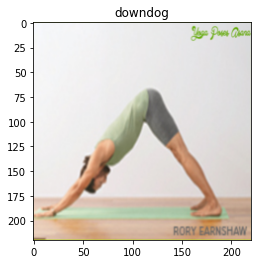

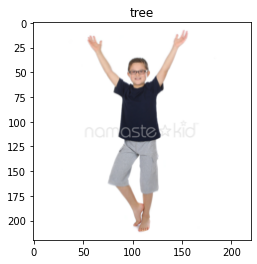

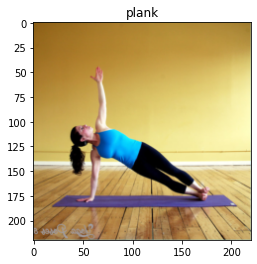

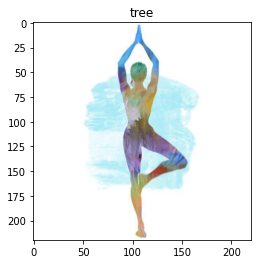

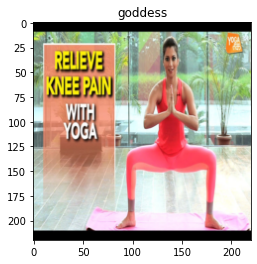

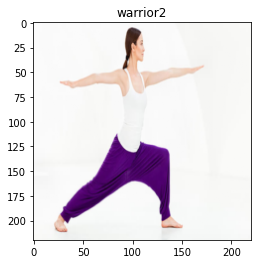

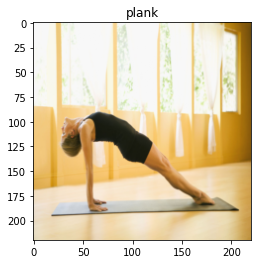

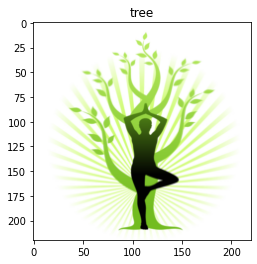

In [9]:
mapping = {
    0 : 'downdog',
    1 : 'goddess',
    2 : 'plank',
    3 : 'tree',
    4 : 'warrior2'
}

def show_sample(data_loader):
    images, labels = next(iter(train_loader))
    for i in range(batch):
        plt.imshow(images[i].permute(1,2,0))
        plt.title(mapping[labels[i].item()])
        plt.show()

show_sample(train_loader)

In [10]:
import torchvision.models as models 
#using resnet pre trained model 
model = models.resnet18(pretrained = True)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
import torch.nn as nn
#Adding FC layer and sigmoid
model.fc = nn.Sequential(
    nn.Linear(512, 5)   #check the output dimension
)
model 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
#freezing all the layers
for params in model.parameters():
    params.requires_grad = False
#Unfreeze last layer 
for params in model.fc.parameters():
    params.requires_grad = True

In [13]:
#setting the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#loss and optimizer for the training
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr = 1e-4)

In [16]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import copy 
#Fine tuning the network 
epochs = 3
for epoch in range(epochs):
    for images, labels in tqdm(train_loader): # a batch of images and their corresponsinf labels would come in loop
        #using cpu gpu
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() #making previous batch values to 0
        model = model.to(device)
        out = model(images)
        #import pdb; pdb.set_trace()
        #out = np.squeeze(out,5)
        # perform broadcasting/resizing for labels to equate with size of output 
        loss = criterion(out, labels)   
        loss.backward() 
        optimizer.step()  #We update the parameters of the model using this function with the gradients obtained

  0%|          | 0/136 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

In [17]:
from scipy.special import softmax
def predict_batch(images, model):
            #using cpu gpu
    images = images.to(device)
    model = model.to(device)
    out = model(images) #just 5 values after linear layer 
    predictions = softmax(out.cpu().detach().numpy(), axis = 1) # [8,5]
    labels = np.argmax(predictions, axis = 1) #row wise -  [8,1] lables size
    return labels 
true_label = []
predict_label = []
for b,l in test_loader :
    true_label.extend(l)
    #print(b.shape)
    p = predict_batch(b, model)
    predict_label.extend(p.tolist())


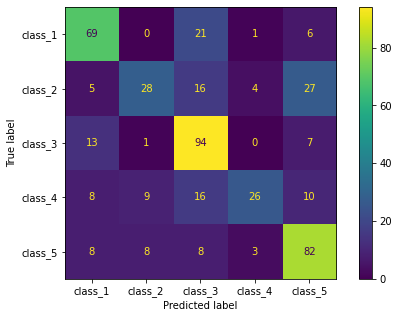

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cmp = ConfusionMatrixDisplay(
    confusion_matrix(true_label, predict_label),
    display_labels=["class_1", "class_2", "class_3", "class_4", "class_5"],
)
fig, ax = plt.subplots(figsize=(8, 5))
cmp.plot(ax=ax)
plt.show();
#f1_score(y_true = true_label, y_pred = predict_label)

In [19]:
accuracy_score(y_true = true_label, y_pred = predict_label)

0.6361702127659574